#AUTOENCODER with SKIPS for DENOISING

this is an autoencoder with skips used to denoise rendered images that are rendered with path traceing at 1 sample per pixel:

INPUTS:
- raw 1spp image
- normal image
- UV image
- shadows image 

#IMPORTS OF SCRIPT

In [ ]:
#IMPORT COMPUTE AND VISUALIZATION LIBs
import matplotlib.pyplot as plt
 
import numpy as np
 
import tensorflow as tf
 
import tensorflow_datasets as tfds
 
from PIL import Image, ImageOps
 
from matplotlib import cm

In [ ]:
#only for EXR files
!pip install --upgrade OpenEXR
!pip install pyexr
import pyexr
import OpenEXR

  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp36-cp36m-linux_x86_64.whl size=188440 sha256=212ec0dac64657518fda7775bb512d70489ee031aa785e47c434997e66879e86
  Stored in directory: /root/.cache/pip/wheels/41/06/9f/c7dc838815b0e7dfc7d7dc19cc3d677edb47594d8489adc62a
Successfully built OpenEXR
  Created wheel for pyexr: filename=PyEXR-0.3.9-py2.py3-none-any.whl size=4508 sha256=5278fa33a17bff1f5cf75937189806524bc6d1fbedbbdda8944c2c8a47330349
  Stored in directory: /root/.cache/pip/wheels/93/f4/aa/c49a29a4cdd86cc622430ee4d313b8b35e7497c6bcbbc49a68
Successfully built pyexr


In [ ]:
#import KERAS for model construction

from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, Lambda, MaxPool2D
from keras.layers import UpSampling2D, Concatenate, Dropout, LSTM, Add, Multiply, Convolution2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import orthogonal
 
import keras.backend as K

#IMPORT FROM DRIVE

In [ ]:
#import of G-drive in order to use dataset stored in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function used to import list of paths of dataset images
import os
imagePath = "drive/My Drive/Datasets/"
 
def loadImages(path, str, ext):
    image_files = sorted([os.path.join(path, str, file) for file in os.listdir(path + "/"+str) if file.endswith('.'+ext)])
    return image_files

In [ ]:
#get all list of images of TRAIN and TEST DATASET

#trainset
datasetTrainColor = loadImages(imagePath + 'TRAINSET','1spp','png')
print(datasetTrainColor[0])
datasetTrainNormal = loadImages(imagePath + 'TRAINSET','normal','png')
datasetTrainShadow = loadImages(imagePath + 'TRAINSET','shadow','png')
datasetTrainUV = loadImages(imagePath + 'TRAINSET','UV','png')
datasetTrain_Y = loadImages(imagePath + 'TRAINSET','reference','png')
 
#testset
datasetTestColor = loadImages(imagePath,'TESTSET/1spp','png')
datasetTestNormal = loadImages(imagePath,'TESTSET/normal','png')
datasetTestShadow = loadImages(imagePath,'TESTSET/shadow','png')
datasetTestUV = loadImages(imagePath,'TESTSET/UV','png')
datasetTest_Y = loadImages(imagePath,'TESTSET/reference','png')

drive/My Drive/Datasets/TRAINSET/1spp/1spp0001 (2).png


In [ ]:
#random seed to shuffle array for train and test
seed = np.random.randint(0,10000)

#FUNCTIONS

In [ ]:
# #import exr as numpy array not used here (can be usefull, not now)

# import Imath
 
# FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
 
# def ExrToNpArray(dataset):
#     imagesInArray = []
#     for im in dataset:
#         image = OpenEXR.InputFile(im)
#         dw = image.header()['dataWindow']
 
#         channels = image.header()['channels'].keys()
#         channels_list = list()
#         for c in ('R','G','B','A'):
#             if c in channels:
#                 channels_list.append(c)
 
#         size = (dw.max.y - dw.min.y+1, dw.max.x - dw.min.x+1)
#         color_channels = image.channels(channels_list, FLOAT)
#         channels_tuple = [np.fromstring(channel, dtype='f') for channel in color_channels]
#         res = np.dstack(channels_tuple)
 
#         imageOut = res.reshape(size + (len(channels_tuple),))
 
#         imagesInArray.append(imageOut)
 
#     imagesInArray = np.array([np.array(fname) for fname in imagesInArray])
#     return imagesInArray
 
# def importFromExr(dataset):
#     imagesInArray = []
#     for im in dataset:
#         image = pyexr.open(im)
 
#         imagesInArray.append(image.get())
 
#     imagesInArray = np.array([np.array(fname) for fname in imagesInArray])
#     return imagesInArray

In [ ]:
#functions for image processing as numpy array

#padding of images in numpy array
def padNpArrayIm(npArray,pad):
    return np.pad(npArray,pad)
 
#cropping of images in numpy array
def cropNpArrayIm(npArray,h_w): #sqare crop h = w = h_w
    numberOfnewImages = int(npArray.shape[0]*int((npArray.shape[1]/h_w))*int((npArray.shape[2]/h_w)))
    print(numberOfnewImages)
    if (len(npArray.shape)>3):
        new_X_train_crop = np.empty((numberOfnewImages,h_w,h_w,npArray.shape[3]))
    else:
        new_X_train_crop = np.empty((numberOfnewImages,h_w,h_w))
    print(new_X_train_crop.shape)
    k = 0
    for element in npArray:
        for y in range(int(npArray.shape[1]/h_w)):
            for x in range(int(npArray.shape[2]/h_w)):
                x_0 = x * h_w
                x_1 = (x+1) * h_w
                y_0 = y * h_w
                y_1 = (y+1) * h_w
                if (len(npArray.shape)>3):
                    new_X_train_crop[k] = element[y_0:y_1,x_0:x_1,:]
                else:
                    new_X_train_crop[k] = element[y_0:y_1,x_0:x_1]
                k += 1
 
    return new_X_train_crop

In [ ]:
#load from images (PIL) to numpy array (NPARRAY)
def loadImageToNumpy(dataset):
    imagesInArray = []
    for im in dataset:
        image = Image.open(im)
        # print(image)
        imagesInArray.append(image)
    imagesInArray = np.array([np.array(fname) for fname in imagesInArray])
    return imagesInArray

##TRAINSET IMPORT

In [ ]:
finalShape = 0

###IMPORT COMPONENTS

####COLOR

In [ ]:
X_train_1spp = loadImageToNumpy(datasetTrainColor)
# datasetTrainColor = 0
print(X_train_1spp.shape)
X_train_1spp = padNpArrayIm(X_train_1spp,((0,0),(24,24),(0,0),(0,0)))
print(X_train_1spp.shape)
finalShape = (X_train_1spp.shape[0],X_train_1spp.shape[1],X_train_1spp.shape[2],X_train_1spp.shape[3])
print(finalShape)

(32, 720, 1280, 3)
(32, 768, 1280, 3)
(32, 768, 1280, 3)


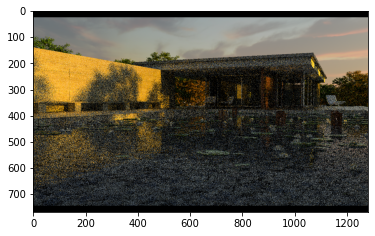

In [ ]:
plt.imshow(X_train_1spp[0])

####NORMAL

In [ ]:
X_train_normal = loadImageToNumpy(datasetTrainNormal)
# datasetTrainNormal = 0
print(X_train_normal.shape)
X_train_normal = padNpArrayIm(X_train_normal,((0,0),(24,24),(0,0),(0,0)))
print(X_train_normal.shape)
finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3]+X_train_normal.shape[3])

(32, 720, 1280, 3)
(32, 768, 1280, 3)


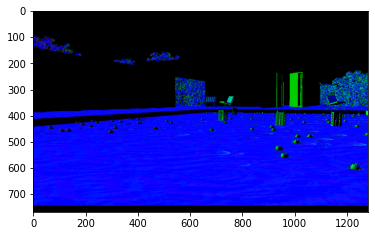

In [ ]:
plt.imshow(X_train_normal[0])

####SHADOW

qui bisogna rimappare e avere solo 1 livello, non servono 3 livelli (B/N)

In [ ]:
X_train_shadow = loadImageToNumpy(datasetTrainShadow)
# datasetTrainShadow = 0
print(X_train_shadow.shape)
X_train_shadow = padNpArrayIm(X_train_shadow,((0,0),(24,24),(0,0),(0,0)))
print(X_train_shadow.shape)

(32, 720, 1280, 3)
(32, 768, 1280, 3)


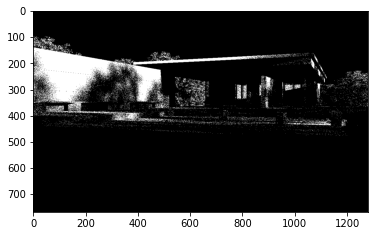

In [ ]:
plt.imshow(X_train_shadow[0,:,:,0], cmap='gray')

In [ ]:
# X_train_shadow = X_train_shadow[:,:,:,0]
# np.reshape(X_train_shadow,(X_train_shadow.shape[0],X_train_shadow.shape[1],X_train_shadow.shape[2],1))
# print(X_train_shadow.shape)

In [ ]:

#get only 1 layer
finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3]+1)

####UV

per le uv ci sono solo 2 canali colore (R e G, cancello il B)

In [ ]:
X_train_uv = loadImageToNumpy(datasetTrainUV)
# datasetTrainUV = 0
print(X_train_uv.shape)
X_train_uv = padNpArrayIm(X_train_uv,((0,0),(24,24),(0,0),(0,0)))
print(X_train_uv.shape)

(32, 720, 1280, 3)
(32, 768, 1280, 3)


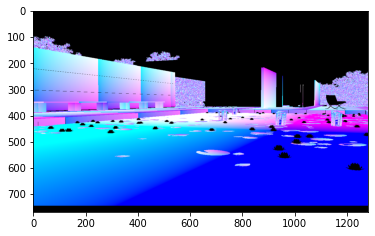

In [ ]:
plt.imshow(X_train_uv[0])

In [ ]:
# temp = np.empty((X_train_uv.shape[0],X_train_uv.shape[1],X_train_uv.shape[2],2))
# temp[:,:,:,0] = X_train_uv[:,:,:,0]
# temp[:,:,:,1] = X_train_uv[:,:,:,1]

# print(temp.shape)
# print(X_train_uv.shape)

In [ ]:
# X_train_uv = temp
# temp = 0

In [ ]:
print(X_train_uv.shape)

(32, 768, 1280, 3)


In [ ]:
#get only 1-2 layer
finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3]+X_train_uv.shape[3])

###Add layers as multiple layers

In [ ]:
# print(finalShape)
# X_train = np.empty(finalShape)
# print(X_train.shape)

# k = 0
# for element in X_train:
#     element[:,:,0:3] = X_train_1spp[k] 
#     element[:,:,3:6] = X_train_normal[k]
#     element[:,:,6] = X_train_shadow[k]
#     element[:,:,7:9] = X_train_uv[k]
#     k +=1

# X_train_1spp = 0
# X_train_normal = 0
# X_train_shadow = 0
# X_train_uv = 0

In [ ]:
# fig, axs = plt.subplots(1, 4)

# axs[0].imshow(X_train[0,:,:,0:3])
# axs[1].imshow(X_train[0,:,:,3:6])
# axs[2].imshow(X_train[0,:,:,6], cmap='gray')
# axs[3].imshow(X_train[0,:,:,6:9])

In [ ]:
print("1spp: ",X_train_1spp.shape)
print("normal: ",X_train_normal.shape)
print("shadow: ",X_train_shadow.shape)
print("uv: ",X_train_uv.shape)

1spp:  (32, 768, 1280, 3)
normal:  (32, 768, 1280, 3)
shadow:  (32, 768, 1280, 3)
uv:  (32, 768, 1280, 3)


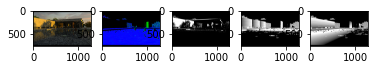

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_train_1spp[0])
axs[1].imshow(X_train_normal[0])
axs[2].imshow(X_train_shadow[0], cmap='gray')
axs[3].imshow(X_train_uv[0,:,:,0], cmap='gray')
axs[4].imshow(X_train_uv[0,:,:,1], cmap='gray')

In [ ]:
# np.random.seed(seed)
# np.random.shuffle(X_train)

In [ ]:
#shuffle all arrays

np.random.seed(seed)
np.random.shuffle(X_train_1spp)
np.random.seed(seed)
np.random.shuffle(X_train_normal)
np.random.seed(seed)
np.random.shuffle(X_train_shadow)
np.random.seed(seed)
np.random.shuffle(X_train_uv)

In [ ]:
# #normalize input
# X_train = X_train.astype('float32')/255.0

In [ ]:
# normalize all arrays

X_train_1spp = X_train_1spp.astype('float32')/255.0
X_train_normal = X_train_normal.astype('float32')/255.0
X_train_shadow = X_train_shadow.astype('float32')/255.0
X_train_uv = X_train_uv.astype('float32')/255.0

In [ ]:
# #giving powers:
# X_train[:,:,:,3:6] *= 0.2
# X_train[:,:,:,6] *= 0.7
# X_train[:,:,:,6:9] *= 0.5

###CROP TRAINSET

In [ ]:
X_train_1spp_crop = cropNpArrayIm(X_train_1spp,128)
X_train_1spp = 0
X_train_normal_crop =cropNpArrayIm(X_train_normal,128)
X_train_normal = 0
X_train_shadow_crop = cropNpArrayIm(X_train_shadow,128)
X_train_shadow = 0
X_train_uv_crop = cropNpArrayIm(X_train_uv,128)
X_train_uv = 0

1920
(1920, 128, 128, 3)
1920
(1920, 128, 128, 3)
1920
(1920, 128, 128, 3)
1920
(1920, 128, 128, 3)


In [ ]:
# X_train_crop = cropNpArrayIm(X_train,128)
# X_train = 0

In [ ]:
# np.random.seed(seed)
# np.random.shuffle(X_train_crop)

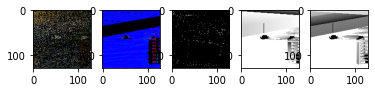

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_train_1spp_crop[1000])
axs[1].imshow(X_train_normal_crop[1000])
axs[2].imshow(X_train_shadow_crop[1000], cmap='gray')
axs[3].imshow(X_train_uv_crop[1000,:,:,0], cmap='gray')
axs[4].imshow(X_train_uv_crop[1000,:,:,1], cmap='gray')

In [ ]:
# plt.imshow(X_train_crop[100,:,:,0:3])

##TRAINSET REFERENCE IMPORT

In [ ]:
Y_train = loadImageToNumpy(datasetTrain_Y)
print(Y_train.shape)

(32, 720, 1280, 3)


In [ ]:
Y_train = padNpArrayIm(Y_train,((0,0),(24,24),(0,0),(0,0)))
print(Y_train.shape)
Y_train = Y_train.astype('float32')/255.0

(32, 768, 1280, 3)


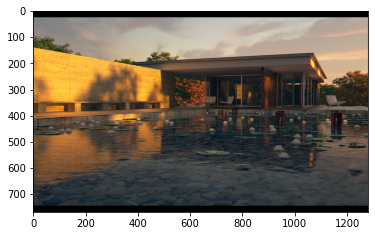

In [ ]:
plt.imshow(Y_train[0])

In [ ]:
np.random.seed(seed)
np.random.shuffle(Y_train)

###Crop trainset reference as numpyArray

In [ ]:
Y_train_crop = cropNpArrayIm(Y_train,128)
Y_train = 0

1920
(1920, 128, 128, 3)


In [ ]:
# np.random.seed(seed)
# np.random.shuffle(Y_train_crop)

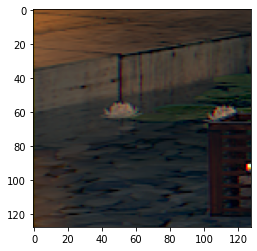

In [ ]:
plt.imshow(Y_train_crop[1000])

In [ ]:
import gc
gc.collect()

11

##TESTSET IMPORT

###IMPORT COMPONENTS

####COLOR

In [ ]:
X_test_1spp = loadImageToNumpy(datasetTestColor)
# datasetTestColor = 0
print(X_test_1spp.shape)
X_test_1spp = padNpArrayIm(X_test_1spp,((0,0),(24,24),(0,0),(0,0)))
print(X_test_1spp.shape)
finalShape = (X_test_1spp.shape[0],X_test_1spp.shape[1],X_test_1spp.shape[2],X_test_1spp.shape[3])
print(finalShape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)
(65, 768, 1280, 3)


####NORMAL

In [ ]:
X_test_normal = loadImageToNumpy(datasetTestNormal)
# datasetTestNormal = 0
print(X_test_normal.shape)
X_test_normal = padNpArrayIm(X_test_normal,((0,0),(24,24),(0,0),(0,0)))
print(X_test_normal.shape)
finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + X_test_normal.shape[3])

(65, 720, 1280, 3)
(65, 768, 1280, 3)


####SHADOW

In [ ]:
X_test_shadow = loadImageToNumpy(datasetTestShadow)
# datasetTestShadow = 0
print(X_test_shadow.shape)
X_test_shadow = padNpArrayIm(X_test_shadow,((0,0),(24,24),(0,0),(0,0)))
print(X_test_shadow.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


In [ ]:
# X_test_shadow = X_test_shadow[:,:,:,0]
# np.reshape(X_test_shadow,(X_test_shadow.shape[0],X_test_shadow.shape[1],X_test_shadow.shape[2],1))
# print(X_test_shadow.shape)

In [ ]:
#get only 1 layer
# finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + 1)

####UV

In [ ]:
X_test_uv = loadImageToNumpy(datasetTestUV)
# datasetTestUV = 0
print(X_test_uv.shape)
X_test_uv = padNpArrayIm(X_test_uv,((0,0),(24,24),(0,0),(0,0)))
print(X_test_uv.shape)

(65, 720, 1280, 3)
(65, 768, 1280, 3)


In [ ]:
# temp = np.empty((X_test_uv.shape[0],X_test_uv.shape[1],X_test_uv.shape[2],2))
# temp[:,:,:,0] = X_test_uv[:,:,:,0]
# temp[:,:,:,1] = X_test_uv[:,:,:,1]

# print(temp.shape)
# print(X_test_uv.shape)

In [ ]:
# X_test_uv = temp
# temp = 0

In [ ]:
print(X_test_uv.shape)

(65, 768, 1280, 3)


In [ ]:
#get only 1-2 layer
# finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + X_test_uv.shape[3])

###Add layers as multiple layers

In [ ]:
# print(finalShape)
# X_test = np.empty(finalShape)
# print(X_test.shape)

# k = 0
# for element in X_test:
#     element[:,:,0:3] = X_test_1spp[k] 
#     element[:,:,3:6] = X_test_normal[k]
#     element[:,:,6] = X_test_shadow[k]
#     element[:,:,7:9] = X_test_uv[k]
#     k +=1

# X_test_1spp = 0
# X_test_normal = 0
# X_test_shadow = 0
# X_test_uv = 0

In [ ]:
# fig, axs = plt.subplots(1, 4)

# axs[0].imshow(X_test[0,:,:,0:3])
# axs[1].imshow(X_test[0,:,:,3:6])
# axs[2].imshow(X_test[0,:,:,6],cmap='gray')
# axs[3].imshow(X_test[0,:,:,6:9])

In [ ]:
print("1spp: ",X_test_1spp.shape)
print("normal: ",X_test_normal.shape)
print("shadow: ",X_test_shadow.shape)
print("uv: ",X_test_uv.shape)

1spp:  (65, 768, 1280, 3)
normal:  (65, 768, 1280, 3)
shadow:  (65, 768, 1280, 3)
uv:  (65, 768, 1280, 3)


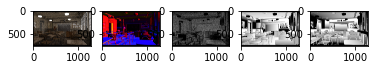

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_test_1spp[0])
axs[1].imshow(X_test_normal[0])
axs[2].imshow(X_test_shadow[0], cmap='gray')
axs[3].imshow(X_test_uv[0,:,:,0], cmap='gray')
axs[4].imshow(X_test_uv[0,:,:,1], cmap='gray')

In [ ]:
# np.random.seed(seed+1000)
# np.random.shuffle(X_test)

In [ ]:
#shuffle all arrays

np.random.seed(seed+1000)
np.random.shuffle(X_test_1spp)
np.random.seed(seed+1000)
np.random.shuffle(X_test_normal)
np.random.seed(seed+1000)
np.random.shuffle(X_test_shadow)
np.random.seed(seed+1000)
np.random.shuffle(X_test_uv)

In [ ]:
# #normalize input
# X_test = X_test.astype('float32')/255.0

In [ ]:
# normalize all arrays

X_test_1spp = X_test_1spp.astype('float32')/255.0
X_test_normal = X_test_normal.astype('float32')/255.0
X_test_shadow = X_test_shadow.astype('float32')/255.0
X_test_uv = X_test_uv.astype('float32')/255.0

In [ ]:
# #giving powers:
# X_test[:,:,:,3:6] *= 0.2
# X_test[:,:,:,6] *= 0.7
# X_test[:,:,:,6:9] *= 0.5

###CROP TESTSET

In [ ]:
X_test_1spp_crop = cropNpArrayIm(X_test_1spp,128)
X_test_1spp = 0
X_test_normal_crop =cropNpArrayIm(X_test_normal,128)
X_test_normal = 0
X_test_shadow_crop = cropNpArrayIm(X_test_shadow,128)
X_test_shadow = 0
X_test_uv_crop = cropNpArrayIm(X_test_uv,128)
X_test_uv = 0

3900
(3900, 128, 128, 3)
3900
(3900, 128, 128, 3)
3900
(3900, 128, 128, 3)
3900
(3900, 128, 128, 3)


In [ ]:
# X_test_crop = cropNpArrayIm(X_test,128)
# X_test = 0

In [ ]:
# np.random.seed(seed+1000)
# np.random.shuffle(X_test_crop)

In [ ]:
# plt.imshow(X_test_crop[100,:,:,0:3])

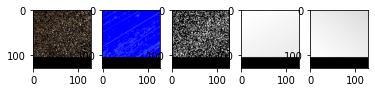

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_test_1spp_crop[50])
axs[1].imshow(X_test_normal_crop[50])
axs[2].imshow(X_test_shadow_crop[50], cmap='gray')
axs[3].imshow(X_test_uv_crop[50,:,:,0], cmap='gray')
axs[4].imshow(X_test_uv_crop[50,:,:,1], cmap='gray')

In [ ]:
gc.collect()

37

##TESTSET REFERENCE IMPORT

In [ ]:
Y_test = loadImageToNumpy(datasetTest_Y)
print(Y_test.shape)

datasetTest_Y = 0

(65, 720, 1280, 3)


In [ ]:
Y_test = padNpArrayIm(Y_test,((0,0),(24,24),(0,0),(0,0)))
print(Y_test.shape)
Y_test = Y_test.astype('float32')/255.0

(65, 768, 1280, 3)


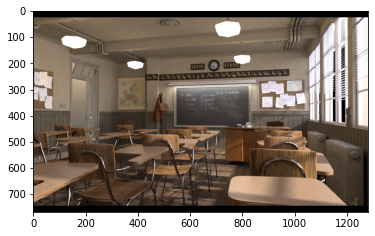

In [ ]:
plt.imshow(Y_test[0])

In [ ]:
np.random.seed(seed+1000)
np.random.shuffle(Y_test)

####Crop testset reference as numpyArray

In [ ]:
Y_test_crop = cropNpArrayIm(Y_test,128)

Y_test = 0

3900
(3900, 128, 128, 3)


In [ ]:
# np.random.seed(seed+1000)
# np.random.shuffle(Y_test_crop)

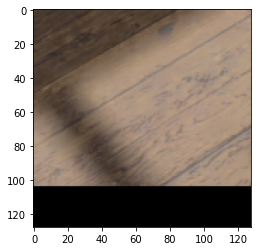

In [ ]:
plt.imshow(Y_test_crop[50])

In [ ]:
gc.collect()

0

#CONTROLLO PARAMETRI INPUT

In [ ]:
#TRAIN

print(X_train_1spp_crop.shape)
print(X_train_normal_crop.shape)
print(X_train_shadow_crop.shape)
print(X_train_uv_crop.shape)

print(Y_train_crop.shape)

#TEST

print(X_test_1spp_crop.shape)
print(X_test_normal_crop.shape)
print(X_test_shadow_crop.shape)
print(X_test_uv_crop.shape)

print(Y_test_crop.shape)


(1920, 128, 128, 3)
(1920, 128, 128, 3)
(1920, 128, 128, 3)
(1920, 128, 128, 3)
(1920, 128, 128, 3)
(3900, 128, 128, 3)
(3900, 128, 128, 3)
(3900, 128, 128, 3)
(3900, 128, 128, 3)
(3900, 128, 128, 3)


#ENCODER

In [ ]:
# in_shape = X_train_crop.shape[1:]
# print('Single input sample shape:', in_shape)

In [ ]:
in_shape_1spp = X_train_1spp_crop.shape[1:]
print('Single input 1 lr:', in_shape_1spp)
in_shape_normal = X_train_normal_crop.shape[1:]
print('Single input 2 lr:', in_shape_normal)
in_shape_shadow = X_train_shadow_crop.shape[1:]
print('Single input 3 lr:', in_shape_shadow)
in_shape_uv = X_train_uv_crop.shape[1:]
print('Single input 4 lr:', in_shape_uv)

Single input 1 lr: (128, 128, 3)
Single input 2 lr: (128, 128, 3)
Single input 3 lr: (128, 128, 3)
Single input 4 lr: (128, 128, 3)


##Definition of Layers

Define convolutional layer and its transpose (multiple layer inside)

CONVOLUTION:
- Conv (with LeakyReLU)
- MaxPooling

DECONVOLUTION:
- UpSampling
- TransposeConv (with LeakyReLU)

In [ ]:
def Convolution2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal(), isfirst=False):
    layerName = f'block_{block_id}_'
    x = Conv2D(filters,kernel_size=kernel, strides=(strides,strides), padding=padding, kernel_initializer=kernel_init, name=layerName+'conv_1', activation='relu')(x)
    # x = LeakyReLU(name=layerName+'lkyReLU_1')(x)
    shapeX = (128,128,filters)
    #print(shapeX)
    # x = Reshape(target_shape=shapeX)(x)
    #print(x.shape)
    if (isfirst == True):
        return x
    
    x = MaxPool2D(pool_size=(2,2), strides=None, padding=padding, name=layerName+'maxPool2D')(x)
    return x

def Transpose_Convolution2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    layerName = f'block_{block_id}_'
    x = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest')(x)
    x = Conv2DTranspose(filters=filters,kernel_size=kernel,strides=(strides,strides),padding=padding,kernel_initializer=kernel_init,name = layerName+'de_conv2d_1', activation='relu')(x)
    # x = LeakyReLU(name=layerName+'lkyReLU_1')(x)
    return x

# def Convolution2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal(), isfirst=False):
#     layerName = f'block_{block_id}_'
#     # x = LSTM(4*filters, recurrent_activation='sigmoid',return_sequences=True)(x)
#     x = Conv2D(filters,kernel_size=kernel, strides=strides, padding=padding, kernel_initializer=kernel_init, name=layerName+'conv_1')(x)
#     x = LeakyReLU(name=layerName+'lkyReLU_1')(x)
#     shapeX = (128,128,filters)
#     #print(shapeX)
#     # x = Reshape(target_shape=shapeX)(x)
#     #print(x.shape)
#     if (isfirst == True):
#         return x
    
#     x = MaxPool2D(pool_size=(2,2), strides=None, padding=padding, name=layerName+'maxPool2D')(x)
#     return x

# def Transpose_Convolution2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
#     layerName = f'block_{block_id}_'
#     x = UpSampling2D(size=(2,2), data_format=None, interpolation='nearest')(x)
#     x = Conv2DTranspose(filters=filters,kernel_size=kernel,strides=strides,padding=padding,kernel_initializer=kernel_init,name = layerName+'de_conv2d_1')(x)
#     x = LeakyReLU(name=layerName+'lkyReLU_1')(x)
#     return x

##Definition of Model Structure

###MODELLO A INPUT SINGOLO

In [ ]:
# #in_shape = (128,128,3)

# inputLR = Input(shape=in_shape, name='ENCODER_INPUT')

# enc1 = Convolution2DLayer(inputLR, 32, 3, strides=1, padding='same', block_id=1, isfirst=True)    #dec5
# print('enc1',enc1.shape)
# enc2 = Convolution2DLayer(enc1, 43, 3, strides=1, padding='same', block_id=2)   #dec4
# print('enc2',enc2.shape)
# enc3 = Convolution2DLayer(enc2, 57, 3, strides=1, padding='same', block_id=3)   #dec3
# print('enc3',enc3.shape)
# enc4 = Convolution2DLayer(enc3, 76, 3, strides=1, padding='same', block_id=4)   #dec2
# print('enc4',enc4.shape)
# enc5 = Convolution2DLayer(enc4, 101, 3, strides=1, padding='same', block_id=5)  #dec1
# print('enc5',enc5.shape)
# enc6 = Convolution2DLayer(enc5, 101, 3, strides=1, padding='same', block_id=6)
# print('enc6',enc6.shape)

# decod1 = Transpose_Convolution2DLayer(enc6, 101, 3, strides= 1, padding='same', block_id=7)
# print('dec1',decod1.shape)
# skip1 = Concatenate(name='skip1')([decod1,enc5])
# enc7 = Convolution2DLayer(skip1,101, 3, strides= 1, padding='same', block_id=8, isfirst=True)
# print('enc7',enc7.shape)
# decod2 = Transpose_Convolution2DLayer(enc7, 76, 3, strides= 1, padding='same', block_id=9)
# print('dec2',decod2.shape)
# skip2 = Concatenate(name='skip2')([decod2,enc4])
# enc8 = Convolution2DLayer(skip2,76, 3, strides= 1, padding='same', block_id=10, isfirst=True)
# print('enc8',enc8.shape)

# decod3 = Transpose_Convolution2DLayer(enc8, 57, 3, strides= 1, padding='same', block_id=11)
# print('dec3',decod3.shape)
# skip3 = Concatenate(name='skip3')([decod3,enc3])
# enc9 = Convolution2DLayer(skip3,57, 3, strides= 1, padding='same', block_id=12, isfirst=True)
# print('enc9',enc9.shape)

# decod4 = Transpose_Convolution2DLayer(enc9, 43, 3, strides= 1, padding='same', block_id=13)
# print('dec4',decod4.shape)
# skip4 = Concatenate(name='skip4')([decod4,enc2])
# enc10 = Convolution2DLayer(skip4,43, 3, strides= 1, padding='same', block_id=14, isfirst=True)
# print('enc10',enc10.shape)

# decod5 = Transpose_Convolution2DLayer(enc10, 32, 3, strides= 1, padding='same', block_id=15)
# print('dec5',decod5.shape)
# skip5 = Concatenate(name='skip5')([decod5,enc1])
# enc11 = Convolution2DLayer(skip5,3, 3, strides= 1, padding='same', block_id=16, isfirst=True)
# print('enc11',enc11.shape)

# autoencoder = Model(inputs= inputLR, outputs= enc11)

In [ ]:
# autoencoder.summary()

###MODELLO A INPUT MULTIPLO

In [ ]:
#in_shape = (128,128,3)

inputLR_1 = Input(shape=in_shape_1spp, name='ENCODER_INPUT_1spp')
inputLR_2 = Input(shape=in_shape_normal, name='ENCODER_INPUT_normal')
inputLR_3 = Input(shape=in_shape_shadow, name='ENCODER_INPUT_shadow')
inputLR_4 = Input(shape=in_shape_uv, name='ENCODER_INPUT_uv')

CombinedInput = Concatenate(axis=-1)([inputLR_1,inputLR_2,inputLR_3,inputLR_4])

print(CombinedInput.shape)


enc1 = Convolution2DLayer(CombinedInput, 32, 3, strides=1, padding='same', block_id=1, isfirst=True)    #dec5
print('enc1',enc1.shape)
enc2 = Convolution2DLayer(enc1, 43, 3, strides=1, padding='same', block_id=2)   #dec4
print('enc2',enc2.shape)
enc3 = Convolution2DLayer(enc2, 57, 3, strides=1, padding='same', block_id=3)   #dec3
print('enc3',enc3.shape)
enc4 = Convolution2DLayer(enc3, 76, 3, strides=1, padding='same', block_id=4)   #dec2
print('enc4',enc4.shape)
enc5 = Convolution2DLayer(enc4, 101, 3, strides=1, padding='same', block_id=5)  #dec1
print('enc5',enc5.shape)
enc6 = Convolution2DLayer(enc5, 101, 3, strides=1, padding='same', block_id=6)
print('enc6',enc6.shape)

decod1 = Transpose_Convolution2DLayer(enc6, 101, 3, strides= 1, padding='same', block_id=7)
print('dec1',decod1.shape)
skip1 = Concatenate(name='skip1')([decod1,enc5])
enc7 = Convolution2DLayer(skip1,101, 3, strides= 1, padding='same', block_id=8, isfirst=True)
print('enc7',enc7.shape)
decod2 = Transpose_Convolution2DLayer(enc5, 76, 3, strides= 1, padding='same', block_id=9)
print('dec2',decod2.shape)
skip2 = Concatenate(name='skip2')([decod2,enc4])
enc8 = Convolution2DLayer(skip2,76, 3, strides= 1, padding='same', block_id=10, isfirst=True)
print('enc8',enc8.shape)

decod3 = Transpose_Convolution2DLayer(enc8, 57, 3, strides= 1, padding='same', block_id=11)
print('dec3',decod3.shape)
skip3 = Concatenate(name='skip3')([decod3,enc3])
enc9 = Convolution2DLayer(skip3,57, 3, strides= 1, padding='same', block_id=12, isfirst=True)
print('enc9',enc9.shape)

decod4 = Transpose_Convolution2DLayer(enc9, 43, 3, strides= 1, padding='same', block_id=13)
print('dec4',decod4.shape)
skip4 = Concatenate(name='skip4')([decod4,enc2])
enc10 = Convolution2DLayer(skip4,43, 3, strides= 1, padding='same', block_id=14, isfirst=True)
print('enc10',enc10.shape)

decod5 = Transpose_Convolution2DLayer(enc10, 32, 3, strides= 1, padding='same', block_id=15)
print('dec5',decod5.shape)
skip5 = Concatenate(name='skip5')([decod5,enc1])
enc11 = Convolution2DLayer(skip5,3, 3, strides= 1, padding='same', block_id=16, isfirst=True)
print('enc11',enc11.shape)

autoencoder = Model(inputs=[inputLR_1,inputLR_2,inputLR_3,inputLR_4] , outputs= enc11)

(None, 128, 128, 12)
enc1 (None, 128, 128, 32)
enc2 (None, 64, 64, 43)
enc3 (None, 32, 32, 57)
enc4 (None, 16, 16, 76)
enc5 (None, 8, 8, 101)
enc6 (None, 4, 4, 101)
dec1 (None, 8, 8, 101)
enc7 (None, 8, 8, 101)
dec2 (None, 16, 16, 76)
enc8 (None, 16, 16, 76)
dec3 (None, 32, 32, 57)
enc9 (None, 32, 32, 57)
dec4 (None, 64, 64, 43)
enc10 (None, 64, 64, 43)
dec5 (None, 128, 128, 32)
enc11 (None, 128, 128, 3)


In [ ]:
autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ENCODER_INPUT_1spp (InputLayer) [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_normal (InputLaye [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_shadow (InputLaye [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
ENCODER_INPUT_uv (InputLayer)   [(None, 128, 128, 3) 0                                            
_______________________________________________________________________________________

##Compiling and Learning of Autoencoder

In [ ]:
# #LOSSES:

# def loss1(y_true,y_pred):

#     l1 =

#     return l1

In [ ]:
autoencoder.compile(loss= 'mean_absolute_error' , optimizer='Adam') #potrei usare come loss lo sqare min errror

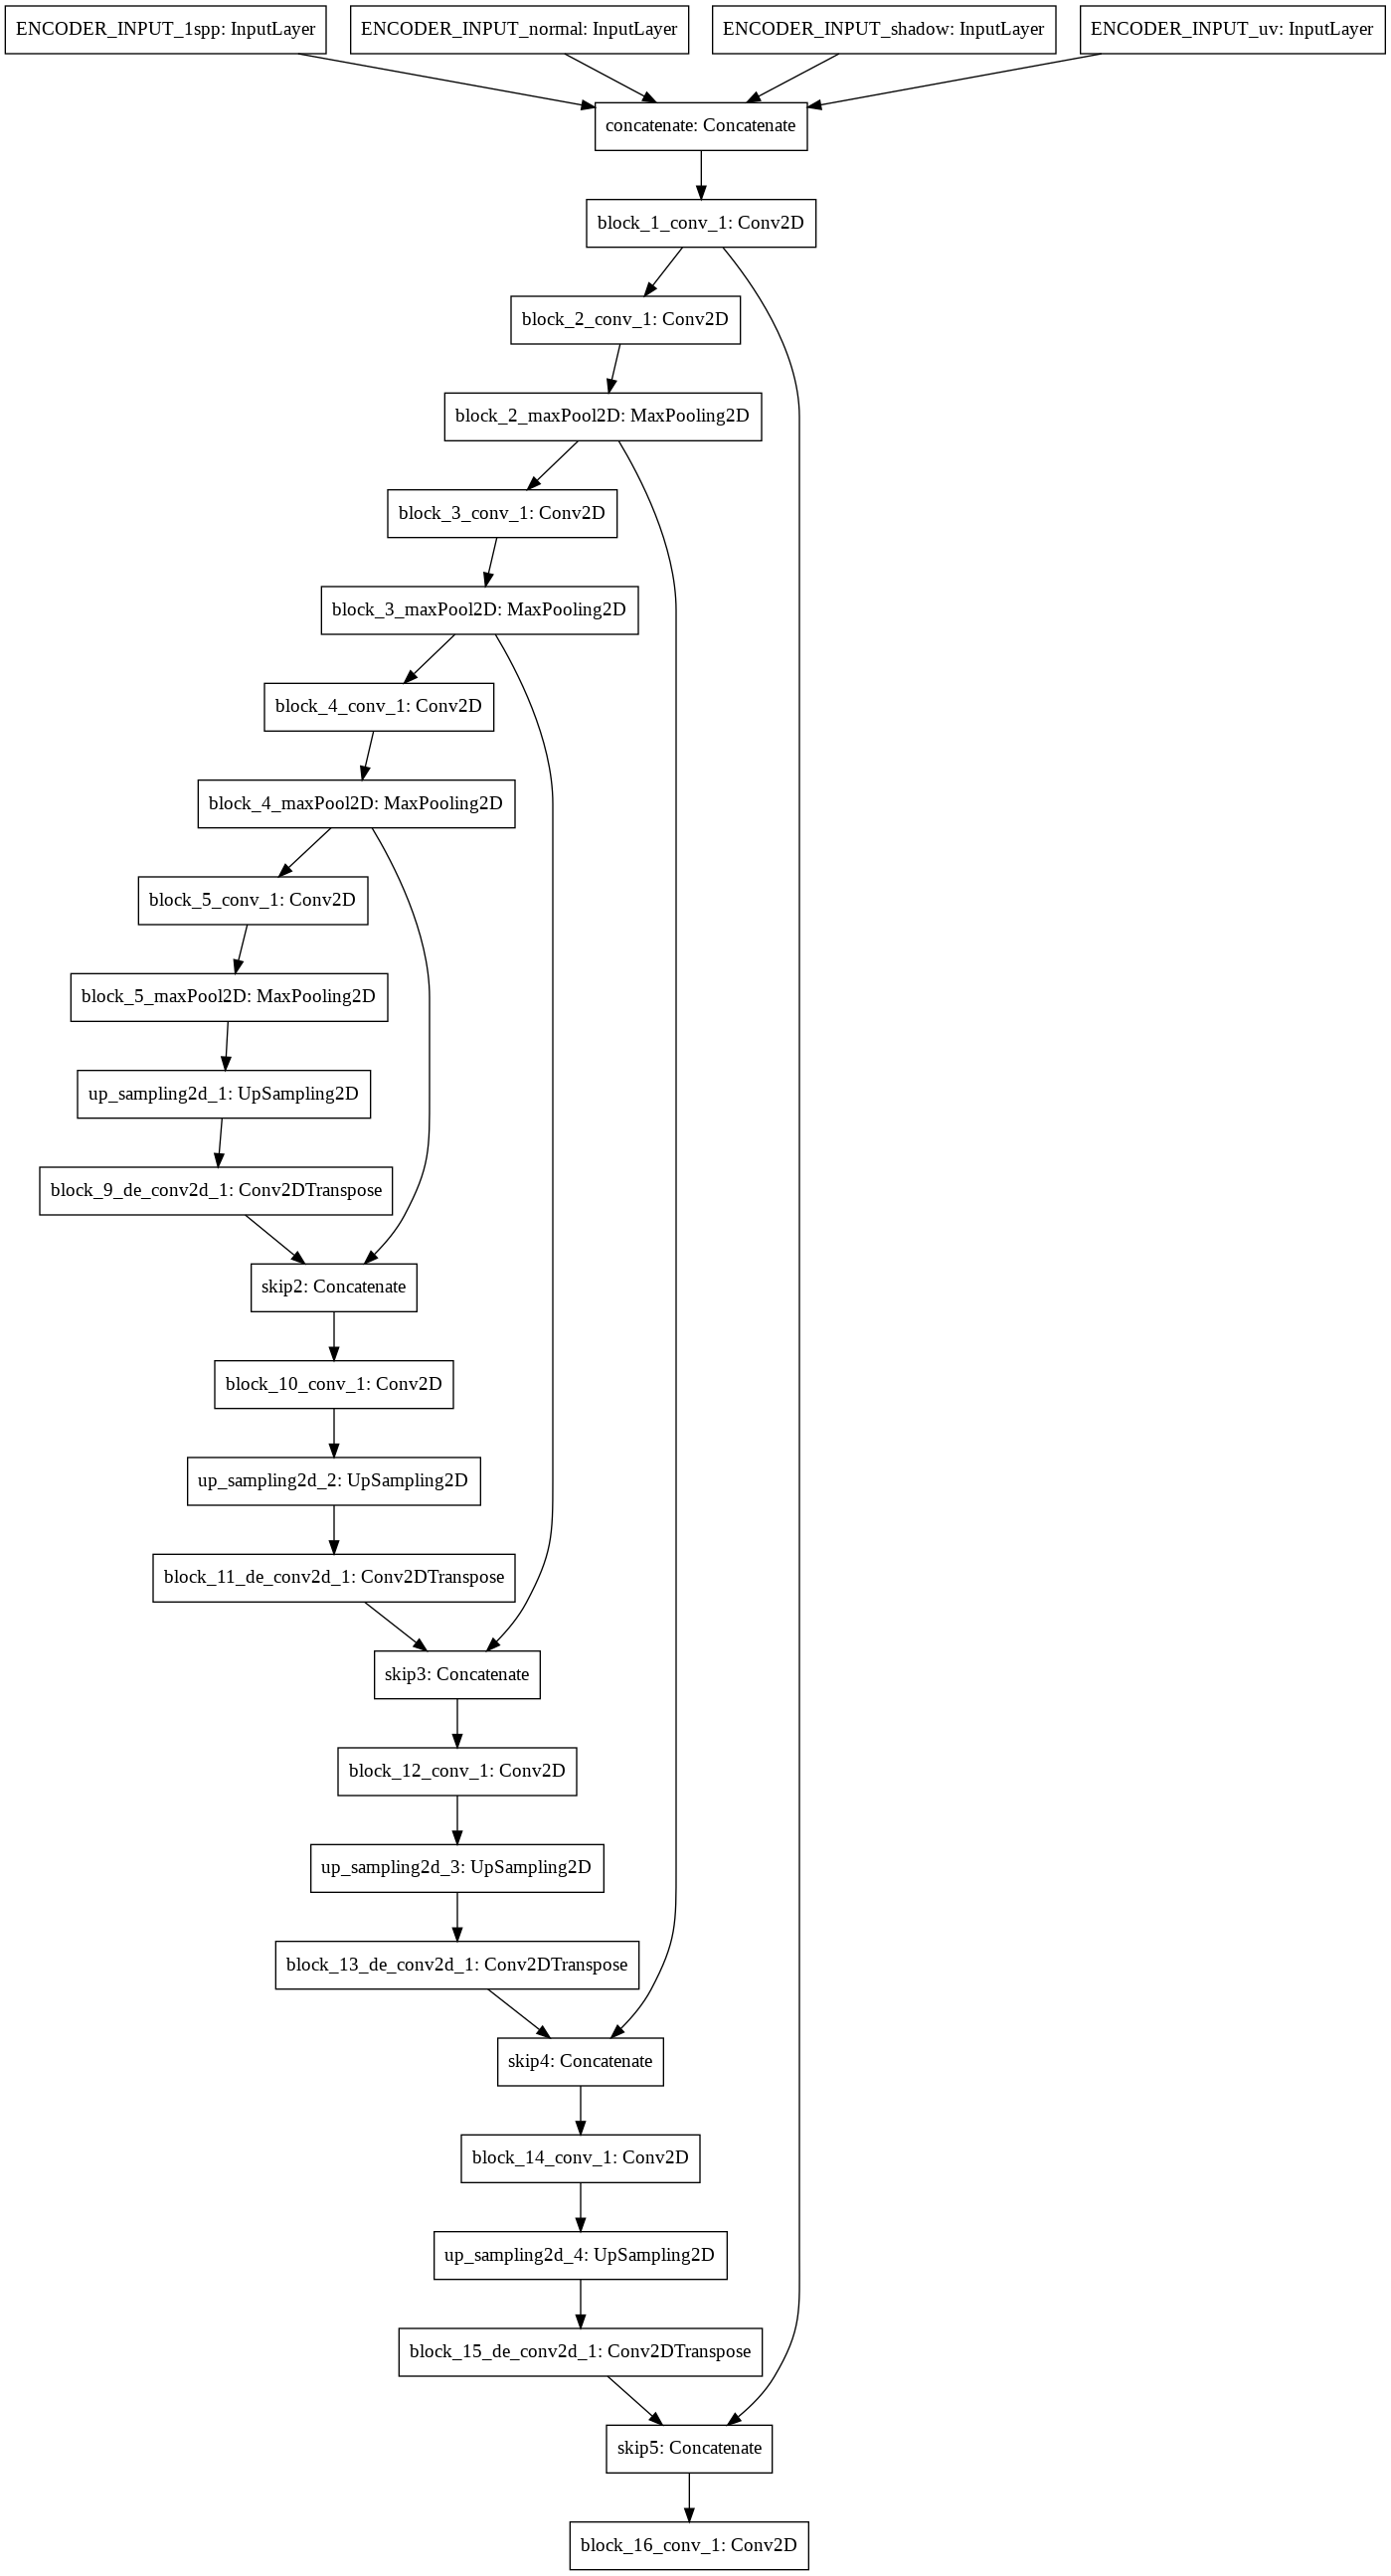

In [ ]:
#Here to plot the model as a png

tf.keras.utils.plot_model(autoencoder)

In [ ]:
autoencoder.fit([X_test_1spp_crop,X_test_normal_crop,X_test_shadow_crop,X_test_uv_crop],Y_test_crop,epochs=20,batch_size=20,validation_data=([X_train_1spp_crop,X_train_normal_crop,X_train_shadow_crop,X_train_uv_crop],Y_train_crop))

Epoch 1/20
195/195 [==============================] - 10s 54ms/step - loss: 0.0745 - val_loss: 0.0766
Epoch 2/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0493 - val_loss: 0.0554
Epoch 3/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0438 - val_loss: 0.0597
Epoch 4/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0398 - val_loss: 0.0553
Epoch 5/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0379 - val_loss: 0.0526
Epoch 6/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0374 - val_loss: 0.0491
Epoch 7/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0363 - val_loss: 0.0533
Epoch 8/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0353 - val_loss: 0.0516
Epoch 9/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0340 - val_loss: 0.0476
Epoch 10/20
195/195 [==============================] - 9s 48ms/step - loss: 0.0339 - val_l

#VALIDATIONSET IMPORT


In [ ]:
#validation
datasetValidationColor = loadImages(imagePath,'VALIDATION/1spp','png')
datasetValidationNormal = loadImages(imagePath,'VALIDATION/normal','png')
datasetValidationShadow = loadImages(imagePath,'VALIDATION/shadow','png')
datasetValidationUV = loadImages(imagePath,'VALIDATION/UV','png')
datasetValidation_Y = loadImages(imagePath,'VALIDATION/reference','png')

##IMPORT COMPONENTS

###COLOR

In [ ]:
X_val_1spp = loadImageToNumpy(datasetValidationColor)
datasetValidationColor = 0
print(X_val_1spp.shape)
X_val_1spp = padNpArrayIm(X_val_1spp,((0,0),(24,24),(0,0),(0,0)))
print(X_val_1spp.shape)
finalShape = (X_val_1spp.shape[0],X_val_1spp.shape[1],X_val_1spp.shape[2],X_val_1spp.shape[3])
print(finalShape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)
(11, 768, 1280, 3)


###NORMAL

In [ ]:
X_val_normal = loadImageToNumpy(datasetValidationNormal)
datasetValidationNormal = 0
print(X_val_normal.shape)
X_val_normal = padNpArrayIm(X_val_normal,((0,0),(24,24),(0,0),(0,0)))
print(X_val_normal.shape)
finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + X_val_normal.shape[3])
print(finalShape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)
(11, 768, 1280, 6)


###SHADOW

In [ ]:
X_val_shadow = loadImageToNumpy(datasetValidationShadow)
datasetValidationShadow = 0
print(X_val_shadow.shape)
X_val_shadow = padNpArrayIm(X_val_shadow,((0,0),(24,24),(0,0),(0,0)))
print(X_val_shadow.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


In [ ]:
# X_val_shadow = X_val_shadow[:,:,:,0]
# np.reshape(X_val_shadow,(X_val_shadow.shape[0],X_val_shadow.shape[1],X_val_shadow.shape[2],1))
# print(X_val_shadow.shape)

In [ ]:
# #only 1 layer

# finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + 1)
# print(finalShape)

###UV

In [ ]:
X_val_uv = loadImageToNumpy(datasetValidationUV)
datasetValidationUV = 0
print(X_val_uv.shape)
X_val_uv = padNpArrayIm(X_val_uv,((0,0),(24,24),(0,0),(0,0)))
print(X_val_uv.shape)

(11, 720, 1280, 3)
(11, 768, 1280, 3)


In [ ]:
# temp = np.empty((X_val_uv.shape[0],X_val_uv.shape[1],X_val_uv.shape[2],2))
# temp[:,:,:,0] = X_val_uv[:,:,:,0]
# temp[:,:,:,1] = X_val_uv[:,:,:,1]

# print(temp.shape)
# print(X_val_uv.shape)

In [ ]:
# X_val_uv = temp
# temp = 0

In [ ]:
print(X_val_uv.shape)

(11, 768, 1280, 3)


In [ ]:
#only layer 1-2

# finalShape = (finalShape[0],finalShape[1],finalShape[2],finalShape[3] + X_val_uv.shape[3])

In [ ]:
print(finalShape)

(11, 768, 1280, 6)


##Add layers as multiple layers

In [ ]:
# print(finalShape)
# X_val = np.empty(finalShape)
# print(X_val.shape)

# k = 0
# for element in X_val:
#     element[:,:,0:3] = X_val_1spp[k] 
#     element[:,:,3:6] = X_val_normal[k]
#     element[:,:,6] = X_val_shadow[k]
#     element[:,:,7:9] = X_val_uv[k]
#     k +=1

# X_val_1spp = 0
# X_val_normal = 0
# X_val_shadow = 0
# X_val_uv = 0

In [ ]:
# fig, axs = plt.subplots(1, 4)

# axs[0].imshow(X_val[0,:,:,0:3])
# axs[1].imshow(X_val[0,:,:,3:6])
# axs[2].imshow(X_val[0,:,:,6], cmap='gray')
# axs[3].imshow(X_val[0,:,:,6:9])

In [ ]:
print("1spp: ",X_val_1spp.shape)
print("normal: ",X_val_normal.shape)
print("shadow: ",X_val_shadow.shape)
print("uv: ",X_val_uv.shape)

1spp:  (11, 768, 1280, 3)
normal:  (11, 768, 1280, 3)
shadow:  (11, 768, 1280, 3)
uv:  (11, 768, 1280, 3)


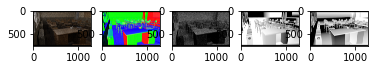

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_val_1spp[0])
axs[1].imshow(X_val_normal[0])
axs[2].imshow(X_val_shadow[0], cmap='gray')
axs[3].imshow(X_val_uv[0,:,:,0], cmap='gray')
axs[4].imshow(X_val_uv[0,:,:,1], cmap='gray')

In [ ]:
#normalize input
# X_val = X_val.astype('float32')/255.0

In [ ]:
# normalize all arrays

X_val_1spp = X_val_1spp.astype('float32')/255.0
X_val_normal = X_val_normal.astype('float32')/255.0
X_val_shadow = X_val_shadow.astype('float32')/255.0
X_val_uv = X_val_uv.astype('float32')/255.0

In [ ]:
# #giving powers:
# X_val[:,:,:,3:6] *= 0.2
# X_val[:,:,:,6] *= 0.9
# X_val[:,:,:,6:9] *= 0.8

##CROP VALIDATIONSET

In [ ]:
#crop for multilayer sovrapposition
def cropForMultiMean(dSet,w_h,shift):
    numberOfImages = int(dSet.shape[0]*int((dSet.shape[1]/shift))*int((dSet.shape[2]/shift))) - (int((dSet.shape[2]/shift)) + int((dSet.shape[1]/shift)))
    print(numberOfImages)
    new_dSet_crop = np.empty((numberOfImages,w_h,w_h,dSet.shape[3]))
    print(new_dSet_crop.shape)

    k = 0
    for element in dSet:
        for y in range(int(dSet.shape[1]/shift) - 1):
            for x in range(int(dSet.shape[2]/shift) - 1):
                x_0 = x * (shift)
                x_1 = w_h + (x * shift)
                y_0 = y * (shift)
                y_1 = w_h + (y * shift)

                # print(y_0,',',y_1,',',x_0,',',x_1)

                new_dSet_crop[k] = element[y_0:y_1,x_0:x_1,:]
                k += 1

    return new_dSet_crop

In [ ]:
# X_val_crop = cropNpArrayIm(X_val,128)
# X_val_crop = cropForMultiMean(X_val,128,64)

In [ ]:
X_val_1spp_crop = cropNpArrayIm(X_val_1spp,128)
# X_val_1spp = 0
X_val_normal_crop =cropNpArrayIm(X_val_normal,128)
# X_val_normal = 0
X_val_shadow_crop = cropNpArrayIm(X_val_shadow,128)
# X_val_shadow = 0
X_val_uv_crop = cropNpArrayIm(X_val_uv,128)
# X_val_uv = 0

660
(660, 128, 128, 3)
660
(660, 128, 128, 3)
660
(660, 128, 128, 3)
660
(660, 128, 128, 3)


In [ ]:
# plt.imshow(X_val_crop[1,:,:,0:3])

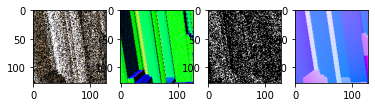

In [ ]:
fig, axs = plt.subplots(1, 4)

axs[0].imshow(X_val_1spp_crop[10])
axs[1].imshow(X_val_normal_crop[10])
axs[2].imshow(X_val_shadow_crop[10])
axs[3].imshow(X_val_uv_crop[10])

##VALIDATIONSET REFERENCE

In [ ]:
Y_val = loadImageToNumpy(datasetValidation_Y)
print(Y_val.shape)

(11, 720, 1280, 3)


In [ ]:
Y_val = padNpArrayIm(Y_val,((0,0),(24,24),(0,0),(0,0)))
print(Y_val.shape)
Y_val = Y_val.astype('float32')/255.0


shapeOfBigIm = Y_val.shape

(11, 768, 1280, 3)


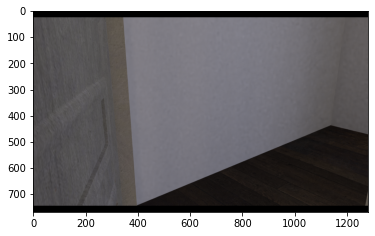

In [ ]:
plt.imshow(Y_val[10])

In [ ]:
Y_val_crop = cropNpArrayIm(Y_val,128)
# Y_val_crop = cropForMultiMean(Y_val,128,64)

660
(660, 128, 128, 3)


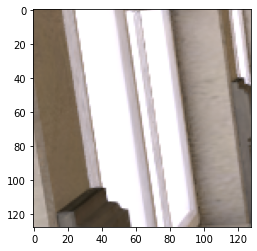

In [ ]:
plt.imshow(Y_val_crop[10])

#PREVISION ON VALIDATIONSET

In [ ]:
imagePredict = autoencoder.predict([X_val_1spp_crop,X_val_normal_crop,X_val_shadow_crop,X_val_uv_crop])

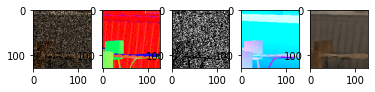

In [ ]:
fig, axs = plt.subplots(1, 5)

axs[0].imshow(X_val_1spp_crop[18])
axs[1].imshow(X_val_normal_crop[18])
axs[2].imshow(X_val_shadow_crop[18])
axs[3].imshow(X_val_uv_crop[18])
axs[4].imshow(imagePredict[18])

#MERGE IMAGE

In [ ]:
def mergingImage(array,shapeOut,h_w):
    arrayOfImageMerged = np.empty(shapeOut)

    k = 0
    for el in arrayOfImageMerged:
        for y in range(int(arrayOfImageMerged.shape[1]/h_w)):
            for x in range(int(arrayOfImageMerged.shape[2]/h_w)):
                x_0 = x * h_w
                x_1 = (x+1) * h_w
                y_0 = y * h_w
                y_1 = (y+1) * h_w
                el[y_0:y_1,x_0:x_1] = array[k]
                k+=1

    return arrayOfImageMerged

def mergingImageShifted(array,shapeOut,h_w,shift):
    arrayOfImageMerged = np.zeros(shapeOut)
    arrayOfImageMerged_count_sum = np.zeros(shapeOut)
    # print(arrayOfImageMerged_count_sum[0,0,0])
    print(arrayOfImageMerged_count_sum.shape)
    # print(arrayOfImageMerged_count_sum[0,0,0])
    k = 0
    nImage = 0 
    for el in arrayOfImageMerged:
        for y in range(int(arrayOfImageMerged.shape[1]/shift)-1):
            for x in range(int(arrayOfImageMerged.shape[2]/shift)-1):
                x_0 = x * (shift)
                x_1 = h_w + (x * shift)
                y_0 = y * (shift)
                y_1 = h_w + (y * shift)
                el[y_0:y_1,x_0:x_1] = np.add(el[y_0:y_1,x_0:x_1], array[k])
                arrayOfImageMerged_count_sum[nImage,y_0:y_1,x_0:x_1,:] = np.add(arrayOfImageMerged_count_sum[nImage,y_0:y_1,x_0:x_1,:], np.ones((128,128,3)))
                # print(k)
                k+=1
        nImage += 1

    arrayOfImageMerged = np.divide(arrayOfImageMerged,arrayOfImageMerged_count_sum)
    # print(arrayOfImageMerged_count_sum[0,0:128,0:128])

    return arrayOfImageMerged

In [ ]:
mergedImages = mergingImage(imagePredict,shapeOfBigIm,128)
# mergedImages = mergingImageShifted(imagePredict,shapeOfBigIm,128,64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


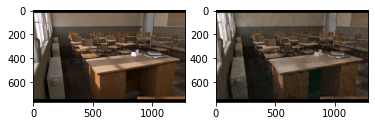

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(Y_val[0])
axs[1].imshow(mergedImages[0])

##OUTPUT OF PREDICTED IMAGES

In [ ]:
im = Image.fromarray(np.uint8(mergedImages[0]*255))
im.save("output1.png","PNG")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


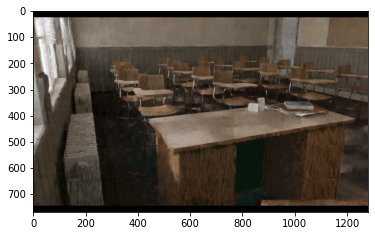

In [ ]:
import cv2

kernel = np.ones((3,3),np.float32)/9

dst = cv2.filter2D(mergedImages[0],-1,kernel)
# dst = cv2.bilateralFilter(np.uint8(mergedImages[0]*255),9,75,75)
plt.imshow(dst)

In [ ]:
im = Image.fromarray(np.uint8(dst*255))
im.save("outputCV21.png","PNG")

#SALVATAGGIO MODELLO

In [ ]:
import tempfile
tmpdir = tempfile.mkdtemp()
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(autoencoder,'drive/My Drive/Datasets')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Datasets/assets


In [ ]:
pip install keras2onnx

     |████████████████████████████████| 102kB 5.3MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 7.7MB 8.7MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=0f3ed9b689ec5a7b2f155b19d0ded4a273a797ba98629fd89d83437d4f5f98bb
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire


In [ ]:

import keras2onnx

# convert to onnx model
onnx_model = keras2onnx.convert_keras(autoencoder,channel_first_inputs=autoencoder.input.name)

temp_model_file = 'modelloNew.onnx'
keras2onnx.save_model(onnx_model, temp_model_file)

AttributeError: ignored